In [1]:
%config IPCompleted.greedy = True

# Import Libraries

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from azureml.core import Dataset, Workspace
from azureml.core.compute import AmlCompute, ComputeTarget
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Import Libraries from root directory
sys.path.append(os.path.abspath('..'))
import library.preprocessing as preprocessing

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luisf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Get Workspace

In [3]:
ws = Workspace.from_config()
ws.get_details()

{'id': '/subscriptions/1f3811a0-1fb9-4d43-974c-8c7bdc025d92/resourceGroups/disasterLocator/providers/Microsoft.MachineLearningServices/workspaces/disasterLocatorML',
 'name': 'disasterLocatorML',
 'location': 'eastus',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'tags': {},
 'sku': 'Basic',
 'workspaceid': '90beb71e-3575-4cbd-af2a-cb2c303edc7b',
 'description': '',
 'friendlyName': 'disasterLocatorML',
 'creationTime': '2020-11-11T14:39:30.8601986+00:00',
 'containerRegistry': '/subscriptions/1f3811a0-1fb9-4d43-974c-8c7bdc025d92/resourceGroups/disasterLocator/providers/Microsoft.ContainerRegistry/registries/90beb71e35754cbdaf2acb2c303edc7b',
 'keyVault': '/subscriptions/1f3811a0-1fb9-4d43-974c-8c7bdc025d92/resourcegroups/disasterlocator/providers/microsoft.keyvault/vaults/disasterlocato9806975694',
 'applicationInsights': '/subscriptions/1f3811a0-1fb9-4d43-974c-8c7bdc025d92/resourcegroups/disasterlocator/providers/microsoft.insights/components/disasterlocato5776021600',
 

# Get Key Vault Secrets

In [4]:
keyvault = ws.get_default_keyvault()
subscription_id = keyvault.get_secret("subscription-id")

# Attach Compute Target

In [5]:
# compute cluster configuration
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "nlp-cpu-cluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target: ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size=vm_size,
                                                                min_nodes=compute_min_nodes,
                                                                max_nodes=compute_max_nodes)
    # create the cluster
    compute_target = ComputeTarget.create(
        ws, compute_name, provisioning_config)

    # can poll for a minimum number of nodes and for a specific timeout.
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(
        show_output=True, min_node_count=None, timeout_in_minutes=20)

    # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

found compute target: nlp-cpu-cluster


# Preprocessing

## Consume Dataset

In [6]:
dataset = Dataset.get_by_name(ws, name='disaster_tweets_train')
tweets_pd = dataset.to_pandas_dataframe()
tweets_pd.dropna(inplace=True)
tweets_pd.reset_index()

,index,id,keyword,location,text,target
0,31,48.0,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1.0
1,32,49.0,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0.0
2,33,50.0,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1.0
3,34,52.0,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0.0
4,35,53.0,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0.0
...,...,...,...,...,...,...
4766,8355,10826.0,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0.0
4767,8357,10829.0,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0.0
4768,8359,10831.0,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0.0
4769,8360,10832.0,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0.0


## Process and Split Training Data

In [7]:
train, test = train_test_split(tweets_pd, test_size=0.4, random_state=42, shuffle=True)
test, validation = train_test_split(test, test_size=0.5, random_state=42, shuffle=True)

In [8]:
print("tweets pd size: ", len(tweets_pd))
print("train size: ", len(train))
print("test size: ", len(test))
print("validation size: ", len(validation))

tweets pd size:  4771
train size:  2862
test size:  954
validation size:  955


In [9]:
X_train, y_train, vocab, max_len = preprocessing.process_dataset(train, tweets_column='text', target_column='target')
X_test, y_test, _, _ = preprocessing.process_dataset(test, vocab, max_len, tweets_column='text', target_column='target')
X_validation, y_validation, _, _ = preprocessing.process_dataset(validation, vocab, max_len, tweets_column='text', target_column='target')

In [10]:
X_train.shape

(2862, 27)

# Convolutional Neural Network Model

In [11]:
def TweetsDisasterClassifier(vocab_size = 1000, embedding_dim=100, max_length=100):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2, padding='valid'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=10, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
model = TweetsDisasterClassifier(vocab_size=len(vocab), embedding_dim=100, max_length=max_len)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 27, 100)           957900    
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 128)           38528     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                15370     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,011,809
Trainable params: 1,011,809
Non-trainable params: 0
______________________________________________

In [13]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=16, epochs=2)

Epoch 1/2
179/179 [==============================] - 4s 21ms/step - loss: 0.6091 - accuracy: 0.6562 - val_loss: 0.5344 - val_accuracy: 0.7424
Epoch 2/2
179/179 [==============================] - 4s 20ms/step - loss: 0.2855 - accuracy: 0.8878 - val_loss: 0.5543 - val_accuracy: 0.7445


## Plot Accuracy

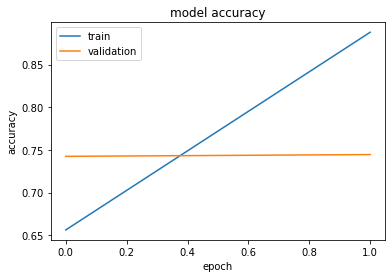

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Plot Loss

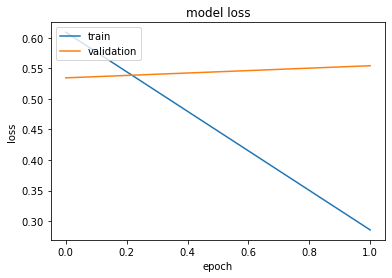

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Measure Test Results

In [16]:
y_pred = model.predict(X_test)
y_pred = [0 if pred < 0.5 else 1 for pred in y_pred]

In [17]:
print("accuracy: ", accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

accuracy:  0.7348008385744235


array([[403, 150],
       [103, 298]], dtype=int64)